<a href="https://colab.research.google.com/github/mnaveed8167/Computer_Vision_Assignments/blob/main/CV_A1_M_Naveed(360918).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from skimage import io
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import joblib
import matplotlib.pyplot as plt
%matplotlib inline


## Loading the Dataset

In [ ]:
def load_objects_data(data_folder):
    data = []
    labels = []
    label_map = {}
    label_count = 0
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if not os.path.isdir(folder_path):
            continue
        if folder not in label_map:
            label_map[folder] = label_count
            label_count += 1
        label = label_map[folder]
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, 0)
            if img is None:
                continue
            data.append(img)
            labels.append(label)
    return data, labels

In [ ]:
objects_train_data, objects_train_labels = load_objects_data("/content/drive/MyDrive/CV-assignment1/Objects_Dataset_Images/train")
objects_test_data, objects_test_labels = load_objects_data("/content/drive/MyDrive/CV-assignment1/Objects_Dataset_Images/test")

In [ ]:
def split_flowers_data(data_folder, test_size=0.2):
    data = []
    labels = []
    label_map = {} # create an empty dictionary to map folder names to label numbers
    label_count = 0 # initialize label_count to zero
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if not os.path.isdir(folder_path):
            continue
        if folder not in label_map: # add new folder name to label_map
            label_map[folder] = label_count
            label_count += 1
        label = label_map[folder]
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, 0)
            if img is None:
                continue
            data.append(img)
            labels.append(label)
    return train_test_split(data, labels, test_size=test_size, stratify=labels, random_state=42)

In [ ]:
flowers_train_data, flowers_test_data, flowers_train_labels, flowers_test_labels = split_flowers_data("/content/drive/MyDrive/CV-assignment1/flower_photos")


## SIFT

In [ ]:
features_extractor = cv2.xfeatures2d.SIFT_create() # create the sift object

train_keypoints = []
train_descriptors = []

test_keypoints = []
test_descriptors = []

for train_img in flowers_train_data:
  train_img_keypoints, train_img_descriptors = features_extractor.detectAndCompute(train_img, None) # extract the keypoints and descriptors for training
  train_keypoints.append(train_img_keypoints) # adding each keypoint in the train list 
  train_descriptors.append(train_img_descriptors) # adding each keypoint in the test list 

for test_img in flowers_test_data:
  test_img_keypoints, test_img_descriptors = features_extractor.detectAndCompute(test_img, None) # extract the keypoints and descriptors for testing
  test_keypoints.append(test_img_keypoints) # adding each descriptors in the train list 
  test_descriptors.append(test_img_descriptors)# adding each descriptors in the test list 

In [ ]:
# Printing the 1st five images descriptors shape
for i in train_descriptors[:5]:
  print(i.shape)

(618, 128)
(1021, 128)
(122, 128)
(1073, 128)
(1028, 128)


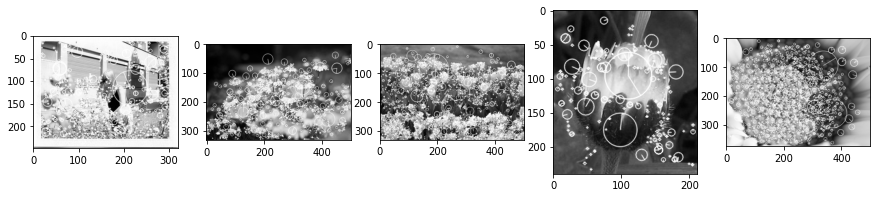

In [ ]:
output_images = []
j = 0
plt.figure(figsize = (15,6))
l = [np.random.randint(800) for i in range(5)]
for i in l:
  output_images.append(cv2.drawKeypoints(flowers_train_data[i], train_keypoints[i], 0, (255,255,255), flags = cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
  ax = plt.subplot(1,5,j+1)
  plt.imshow(output_images[j])
  j += 1
plt.show()

In [ ]:
features_extractor = cv2.xfeatures2d.SIFT_create() # create the sift object

train_keypoints = []
train_descriptors = []

test_keypoints = []
test_descriptors = []

for train_img in objects_train_data:
  train_img_keypoints, train_img_descriptors = features_extractor.detectAndCompute(train_img, None) # extract the keypoints and descriptors for training
  train_keypoints.append(train_img_keypoints) # adding each keypoint in the train list 
  train_descriptors.append(train_img_descriptors) # adding each keypoint in the test list 

for test_img in objects_test_data:
  test_img_keypoints, test_img_descriptors = features_extractor.detectAndCompute(test_img, None) # extract the keypoints and descriptors for testing
  test_keypoints.append(test_img_keypoints) # adding each descriptors in the train list 
  test_descriptors.append(test_img_descriptors)# adding each descriptors in the test list 

In [ ]:
# Printing the 1st five images descriptors shape
for i in train_descriptors[:5]:
  print(i.shape)

(935, 128)
(442, 128)
(409, 128)
(250, 128)
(81, 128)


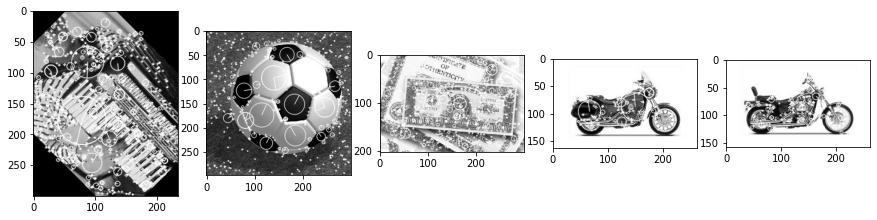

In [ ]:
output_images = []
j = 0
plt.figure(figsize = (15,6))
l = [np.random.randint(50) for i in range(5)]
for i in l:
  output_images.append(cv2.drawKeypoints(objects_train_data[i], train_keypoints[i], 0, (255,255,255), flags = cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
  ax = plt.subplot(1,5,j+1)
  plt.imshow(output_images[j])
  j += 1
plt.show()

## Visulize the Extracted Features

## Stack all the training descriptors

In [ ]:
train_all_descriptors = []
test_all_descriptors = []

# storing all the descriptors of each image in one list
for train_des in train_descriptors:
  for local_descriptor in train_des:
    train_all_descriptors.append(local_descriptor) 

# storing all the descriptors of each image in one list
for test_des in test_descriptors:
  for local_descriptor in test_des:
    test_all_descriptors.append(local_descriptor)

train_all_descriptors = np.stack(train_all_descriptors)
test_all_descriptors = np.stack(test_all_descriptors)

In [ ]:
train_all_descriptors.shape, test_all_descriptors.shape

((25082, 128), (3113, 128))

Now we have all descriptors (128 dimensional vector) across all images. There are around 46376

## Clustering K-means

In [ ]:
k = 150 # number of clusters
iters = 1
codebook, variance = kmeans(train_all_descriptors, k, iters, seed = 10) # constructing a codebook

In [ ]:
print(f'Codebook Shape{codebook.shape}')

Codebook Shape(150, 128)


## Vector quantization

In [ ]:
train_visual_words = []
test_visual_words = []

for train_img_descriptors in train_descriptors:
  train_img_visual_words, distance = vq(train_img_descriptors, codebook)
  train_visual_words.append(train_img_visual_words)

for test_img_descriptors in test_descriptors:
  test_img_visual_words, distance = vq(test_img_descriptors, codebook)
  test_visual_words.append(test_img_visual_words)

In [ ]:
# visual words looke like for image 0
print(f'Visual words in Image 0: {train_visual_words[0][:]}')

Visual words in Image 0: [ 32  63  81  95 137 104  80  66  66  26  83  84  81  90  45  65  17  93
  17  32  32  66 136   0  89  32 104 115  65  72 135 104  86  65  92  65
  77 104  86  80 126  26  80 101  80 130  63 117 113  31  38 119 128 113
  87 134  84 117  80  64  63 107 142 104  26  60   0  76  53  72  84  65
 112   1  93  80  45  56  64  18  64  45  77  80  96  32 130 104  84  75
  80  75  80  39  80 126  62  18 113  63  32  54 107  75  75 115 104 149
 134   0  24  94  28  17  53  79  31  47  95  70  45  76  47 149  63  14
 128  82  79  93 115  80  18 130  36  45  80  95  46  65  85  45  82 146
 149  81  80 104  62 126  17  93 136  14   1  18  46  81  48  33  26  26
  35  83  93  85 110  34  70  45 144  80  66  37   1 126  80 128  31  75
 112  70  32  63  34  71  14  32 104  22  62  65 104  84  32  32  22  75
  75  32 149  66  32  93 104  22 125  92  90  71  80  26 132  87  20  65
 134  65 107  48 115  79 104 123 123  75  62 126  93  99 126  18 134  81
  65 104  14 108  81  93  

Each of these values 143, 156, 21, 72, 193 etc., represent a centroid from a codebook

## Frequency count

In [ ]:
train_frequency_vectors = []
test_frequency_vectors = []

for img_visual_words in train_visual_words:
  img_frequency_vector = np.zeros(k) # k is the number of cluster (200)
  for word in img_visual_words:
    img_frequency_vector[word] += 1 # counting the frequency of the visual words 
  train_frequency_vectors.append(img_frequency_vector) 

for img_visual_words in test_visual_words:
  img_frequency_vector = np.zeros(k) # k is the number of cluster (200)
  for word in img_visual_words:
    img_frequency_vector[word] += 1 # counting the frequency of the visual words 
  test_frequency_vectors.append(img_frequency_vector)

train_frequency_vectors = np.stack(train_frequency_vectors)
test_frequency_vectors = np.stack(test_frequency_vectors)

In [ ]:
train_frequency_vectors.shape, test_frequency_vectors.shape

((56, 150), (8, 150))

### complete vocabulary generated

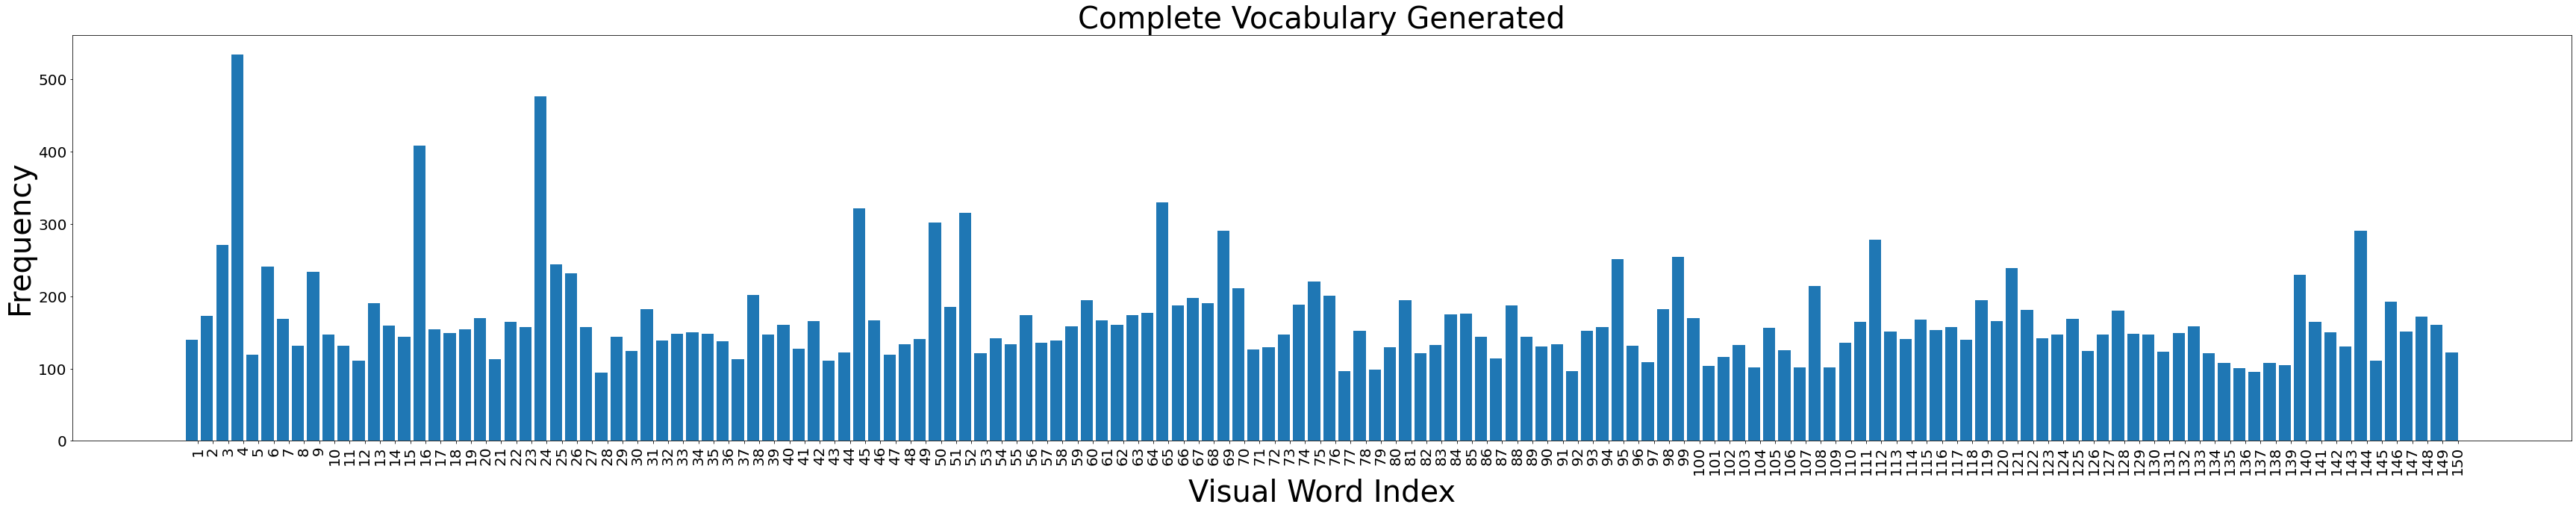

In [ ]:
x_scalar = np.arange(1,k+1)
y_scalar = np.array([abs(np.sum(train_frequency_vectors[:,h], dtype=np.int32)) for h in range(k)])
plt.figure(figsize = (60,10))
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index", fontsize = 40)
plt.ylabel("Frequency", fontsize = 40)
plt.title("Complete Vocabulary Generated", fontsize = 40)
plt.xticks(x_scalar + 0.4, x_scalar, rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('complete vocabulary generated.jpg')
plt.show()

### Frequencies of 1st 4 images

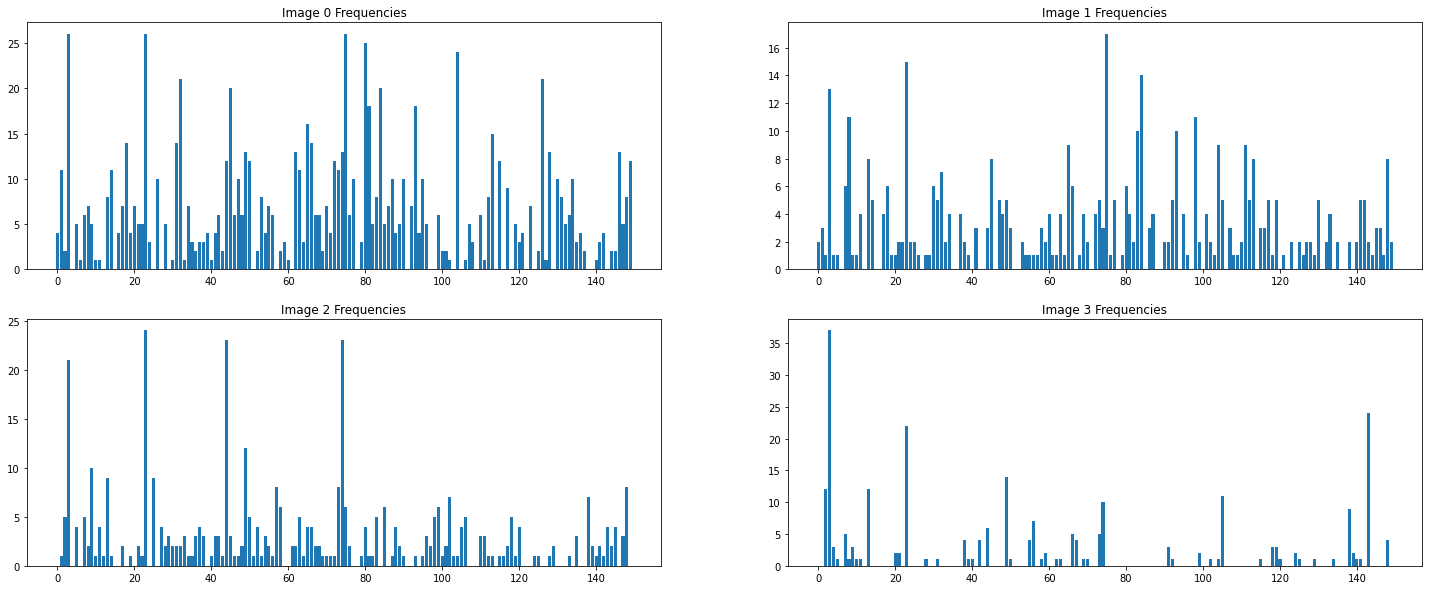

In [ ]:
plt.figure(figsize = (25,10))
for i in range(4):
  ax = plt.subplot(2,2,i+1)
  plt.bar(list(range(k)), train_frequency_vectors[i])
  plt.title(f'Image {i} Frequencies')
plt.savefig('Images Frequencies.jpg')
plt.show()

## Scaling the words

In [ ]:
# Scaling the words
stdSlr = StandardScaler().fit(train_frequency_vectors)
train_features = stdSlr.transform(train_frequency_vectors) # Normalizing the train features
test_features = stdSlr.transform(test_frequency_vectors) # Normalizing the test features

## SVM Model

In [ ]:
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
clf = LinearSVC(max_iter = 10000, random_state = 22)  #Default of 100 is not converging
clf.fit(train_features, np.array(objects_train_labels))

LinearSVC(max_iter=10000, random_state=22)

## Predictions

In [ ]:
predictions =  [i for i in clf.predict(test_features)] # predict the test features and store in the list

## Metrics

### Accuracy

In [ ]:
accuracy = accuracy_score(objects_test_labels, predictions)
print ("Accuracy = ", np.round(accuracy,2)*100)

Accuracy =  0.0


### Classificarion Report

In [ ]:
print(classification_report(objects_test_labels, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       2.0
           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       2.0

    accuracy                           0.00       8.0
   macro avg       0.00      0.00      0.00       8.0
weighted avg       0.00      0.00      0.00       8.0



### Confusion Matrix

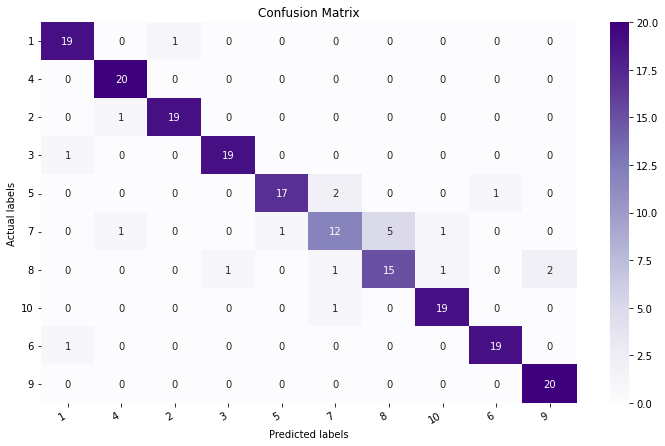

In [ ]:
class_names = [1,4,2,3,5,7,8,10,6,9]
def show_confusion_matrix1atrix(confusion_matrix1atrix):
  plt.figure(figsize = (12,7))
  hmap = sns.heatmap(confusion_matrix1atrix, annot=True, fmt="d", cmap="Purples")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual labels')
  plt.xlabel('Predicted labels')
  plt.title('Confusion Matrix');
  plt.savefig('Confusion Matrix.jpg')
  plt.show()
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix1atrix(df_cm)

### Positive and Negative Rate

In [ ]:
confusion_matrix1 = pd.DataFrame(cm)
FP = confusion_matrix1.sum(axis=0) - np.diag(confusion_matrix1)  
FN = confusion_matrix1.sum(axis=1) - np.diag(confusion_matrix1)
TP = np.diag(confusion_matrix1)
TN = confusion_matrix1.values.sum() - (FP + FN + TP)

TPR = np.round(TP/(TP+FN),2) # Sensitivity, hit rate, recall, or true positive rate

TNR = np.round(TN/(TN+FP),2)  # Specificity or true negative rate

FPR = np.round(FP/(FP+TN),2)# Fall out or false positive rate

FNR = np.round(FN/(TP+FN),2) # False negative rate

## Predictions Visualization

In [ ]:
correctly_class = []
incorrectly_class = []
for i in range(len(predictions)):
  if (test_labels[i] == predictions[i]) == True: 
    correctly_class.append(i) # store all the correctly classified classes
  else:
    incorrectly_class.append(i) # store all the incorrectly classified classes

### Correctly Classified

NameError: ignored

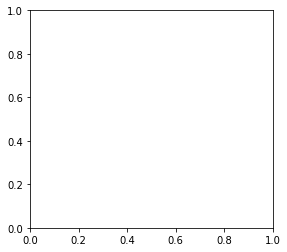

In [60]:
plt.figure(figsize = (20,4))
for i in range(4):
  ax = plt.subplot(1,4,i+1)
  rand_idx = random.randrange(len(correctly_class))
  plt.title(f'Actual Label: {test_labels[correctly_class[rand_idx]]}\nPredicted label: {predictions[correctly_class[rand_idx]]}')
  plt.imshow(test_images[correctly_class[rand_idx]])
plt.savefig('correctly Classified')

### Incorrectly Classified

NameError: ignored

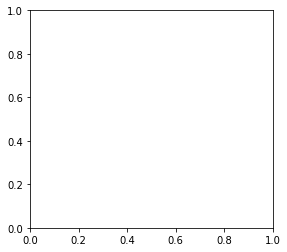

In [61]:
plt.figure(figsize = (20,4))
for i in range(4):
  ax = plt.subplot(1,4,i+1)
  rand_idx = random.randrange(len(incorrectly_class))
  plt.title(f'Actual Label: {test_labels[incorrectly_class[rand_idx]]}\nPredicted label: {predictions[incorrectly_class[rand_idx]]}')
  plt.imshow(test_images[incorrectly_class[rand_idx]])
plt.savefig('Incorrectly Classified')

## Supervised Learning

### Kmeans model

In [ ]:
kmeans = KMeans(n_clusters = k, init='random', random_state=22)

### Fitting model on train descriptors

In [ ]:
kmeans = kmeans.fit(train_all_descriptors)

### Get the labels

In [ ]:
labels = kmeans.labels_

### Dimensionality reduction